# Generalization


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import torch

from tqdm.notebook import tqdm, trange

from main import *

params = {
      'text.usetex': True,
      'font.family': 'sans serif'
}
matplotlib.rcParams.update(params)

## Load models

In [4]:
def load_exp(name, step="last", log=True, dataloaders=False):
    """ Load an experiment with a given name. step can be an integer, "best", or "last" (default). """
    exp_dir = Path("models") / name

    with open(exp_dir / "args.json") as f:
        args_dict = json.load(f)

    # Invert B subsets
    data_subset = eval(args_dict["data_subset"])
    if data_subset.stop == None:
        data_subset = slice(-1, data_subset.start - 1, -1)
    args_dict["data_subset"] = str(data_subset)

    ctx = TrainingContext(**args_dict, step=step, key_remap=None, seed=None, dataloaders=dataloaders, writer=False)
    if log:
        print(f"{name}: retrieved model at step {ctx.step} and test loss {ctx.test_perf.loss:.2e}")

    # Disable DataParallel (needed for Hessian computation)
    ctx.model.network = ctx.model.network.module

    # Put in eval mode and disable gradients with respect to all parameters.
    ctx.model.eval()
    for p in ctx.model.parameters():
        p.requires_grad = False

    return ctx

# All subsets A are non-overlapping with all subsets B. But subsets A and B are nested within each other (first or last images in the dataset).
Ns = [1, 10, 100, 1_000, 10_000, 100_000]
ctxs = {}
for N in Ns:
    for subset in ["A", "B"]:
        # ctx = load_exp(f"cvgscaling_imagenet64_subN{N}{subset}_noisescore1_nsexp0", dataloaders=N == Ns[-1])
        ctx = load_exp(f"finalcvg_imagenet64_color_subN{N}{subset}_lr0.0002_1Msteps10decays", dataloaders=N == Ns[-1])
        ctxs[N, subset] = ctx
default_ctx = ctxs[Ns[-1], "A"]
device = default_ctx.device
dataset_info = default_ctx.dataset_info
d = dataset_info.dimension

# Dataloaders have horizontal flips.
# train_dataloader_color = ctxs["color"].new_dataloader(train=True, batch_size=1024)
# test_dataloader_color = ctxs["color"].new_dataloader(train=False, batch_size=1024)
# train_dataloader_grayscale = ctxs["grayscale"].new_dataloader(train=True, batch_size=1024)
# test_dataloader_grayscale = ctxs["grayscale"].new_dataloader(train=False, batch_size=1024)

finalcvg_imagenet64_color_subN1A_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 2.29e+00
finalcvg_imagenet64_color_subN1B_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 8.09e+00
finalcvg_imagenet64_color_subN10A_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 1.78e+02
finalcvg_imagenet64_color_subN10B_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 2.30e+02
finalcvg_imagenet64_color_subN100A_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 1.73e+00
finalcvg_imagenet64_color_subN100B_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 1.68e+00
finalcvg_imagenet64_color_subN1000A_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 4.35e-01
finalcvg_imagenet64_color_subN1000B_lr0.0002_1Msteps10decays: retrieved model at step 1000000 and test loss 4.24e-01
finalcvg_imagenet64_color_subN10000A_lr0.0002_1Msteps10decays: retrieved mod

## Compute energies

In [5]:
# Compare their probabilities on clean grayscale images

def samples_energy(dataloader, t=0):
    default_ctx.time_tracker.reset()

    xs = []
    es = defaultdict(list)
    for x in tqdm(dataloader):
        x = x[0]
        xs.append(x.cpu())
        clean = x.cuda()
        input = model_input(clean, noise_level=t)

        default_ctx.time_tracker.switch("forward")
        for k, c in ctxs.items():
            if k == "color":
                continue
            output = c.model(input, compute_scores=False, create_graph=False)  # (B,)
            es[k].append(output.energy.cpu())

    print(default_ctx.time_tracker.pretty_print())

    xs = torch.cat(xs, dim=0)
    es = {k: torch.cat(e, dim=0) for k, e in es.items()}
    return xs, es

# # Compute normalization constant by computing average energy at large noise level (for accuracy)
# t = 1e3
# _, energies_t = samples_energy(default_ctx.new_dataloader(train=False, batch_size=1024), t=t)
# log_normalization_constants = {}
# for k, e in energies_t.items():
#     log_normalization_constant = ctxs[k].dataset_info.dimension/2 * np.log(2 * np.pi * np.e * t) - e.mean()
#     print(f"Log normalization constant for {k}: {log_normalization_constant.item():.4}")  # To be compared against entropy of 2e5
#     ctxs[k].model.log_normalization_constant = log_normalization_constant
#     log_normalization_constants[k] = log_normalization_constant

# xA, eA = samples_energy(ctxs[Ns[-1], "A"].new_dataloader(train=True, batch_size=1024, num_samples=1024))
# xB, eB = samples_energy(ctxs[Ns[-1], "B"].new_dataloader(train=True, batch_size=1024, num_samples=1024))
# torch.save((log_normalization_constant, eA, eB), "outputs/energies_generalization.pt")
(log_normalization_constant, eA, eB) = torch.load("outputs/energies_generalization.pt")
c = lambda e: LogTensor(e, d).to(base="dBs", sign="logp", per_dimension=True)

## Generalization scatter plots

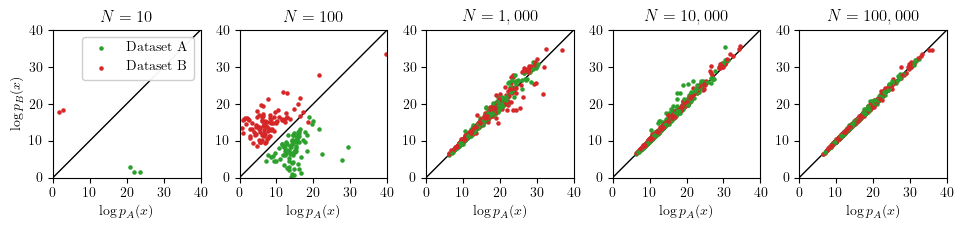

In [6]:
# Scatter plots of above histograms.
plt.figure(figsize=(11, 2.5), layout="constrained")
for i, N in enumerate(Ns[1::]):
    plt.subplot(1, len(Ns), i+1)
    plt.xlabel("$\log p_A(x)$")
    if N ==10:
        plt.ylabel("$\log p_B(x)$")
    t = [0, 40]
    plt.plot(t, t, color="black", zorder=-2, lw = 1)

    n = min(N, 1000)
    for i, idx in enumerate(torch.arange(n).split(5)):  # Overlay points
        scatter = lambda x, y, label, **kwargs: plt.scatter(c(x).cpu().numpy(), c(y).cpu().numpy(), s=5, label=label if i == 0 else None, rasterized=True, **kwargs)
        scatter(eA[N, "A"][idx], eA[N, "B"][idx], label="Dataset A", color="tab:green")
        scatter(eB[N, "A"][idx], eB[N, "B"][idx], label="Dataset B", color="tab:red")

    ticks = [0, 10, 20, 30, 40]
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(f"$N = {N:,}$")
    plt.gca().set_aspect('equal')
    lim = (0, 40)
    plt.xlim(*lim)
    plt.ylim(*lim)

    if N == 10:
        plt.legend(framealpha=0.95)
plt.savefig("outputs/generalization.pdf", transparent=True, bbox_inches="tight", pad_inches=0, dpi=600)
plt.show()

tensor(0.0285) tensor(0.1106) tensor(0.1860)


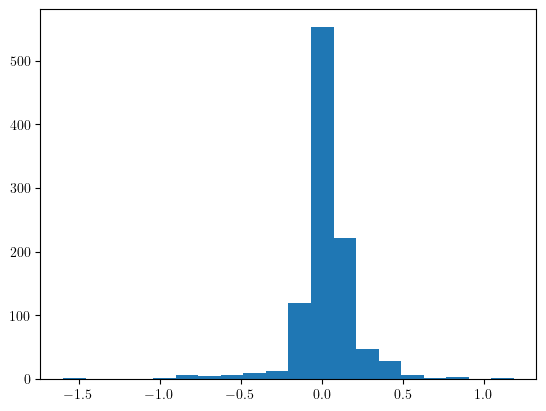

In [25]:
diff = c(eA[Ns[-1], "A"] - eA[Ns[-1], "B"])
plt.hist(diff.cpu().numpy(), bins=20)
print(diff.mean(), torch.abs(diff).mean(), torch.sqrt((diff ** 2).mean()))